In [72]:
# https://www.kaggle.com/lodetomasi1995/income-classification
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from io import StringIO
from sklearn.model_selection import cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint as pp
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import time
import os
from sklearn.preprocessing import LabelEncoder

In [55]:
dd = os.getcwd()
np.random.seed(0)

In [56]:
df = pd.read_csv("../../Data/income_evaluation.csv")
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df = df.dropna()
df = df.ffill()
df = df.bfill()
df.shape
df.columns = list(map(lambda x: x.strip(), df.columns))

In [57]:
price_range = df[['income']].to_numpy()
price_range[price_range=="<=50K"] = 0
price_range[price_range==">50K"] = 1
df['income'] = pd.DataFrame(price_range, columns=['income'])
y_new = pd.DataFrame(price_range, columns=['income'])


In [58]:
# Do a one-hot encoding of string features - otherwise the predict method will fail
for i in df.columns:
    if i in ['workclass', 'education','marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']:
        df[i] = LabelEncoder().fit_transform(df[i])

In [59]:
X = df.drop(columns=['income', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss'])
y = y_new
y=y.astype('int')
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
df[['income']].value_counts()

income
0         24720
1          7841
dtype: int64

In [73]:
clf = DecisionTreeClassifier(random_state=0)
start_time = time.time()
clf.fit(x_train, y_train)
print(f"DT Normal Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred = clf.predict(x_test)
print(f"DT Normal Model: Fit Time: {time.time() - start_time}")
print(f"Number of Nodes in the tree {clf.tree_.node_count}")
print(accuracy_score(y_test, y_pred))

DT Normal Model: Fit Time: 0.04378485679626465
DT Normal Model: Fit Time: 0.0019359588623046875
Number of Nodes in the tree 11315
0.7796714263780132


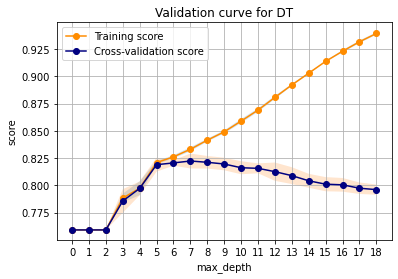

In [63]:
### Validation Curve ###
depth_range = np.arange(1, 20)
classifier = "DT"
param_name = "max_depth"
train_scores, test_scores = validation_curve(clf, x_train, y_train, param_name=param_name, param_range=depth_range, cv=5)
mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)
depth_range_list = np.arange(0, len(depth_range), 1)
plt.figure()
plt.xticks(np.arange(0, len(depth_range)))
plt.plot(depth_range_list, mean_train_scores, 'o-', label='Training score', color='darkorange')
plt.fill_between(depth_range_list, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, alpha=0.2)
plt.plot(depth_range_list, mean_test_scores, 'o-', label='Cross-validation score', color='navy')
plt.fill_between(depth_range_list, mean_test_scores - std_test_scores, mean_test_scores + std_test_scores, alpha=0.2)
plt.title(f'Validation curve for {classifier}')
plt.xlabel(param_name)
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
plt.savefig(os.getcwd() + '/dt_validation_curve_income.png')
plt.show()

In [13]:
fit_time_list = []
predict_time_list = []
number_nodes_list = []
for i in np.arange(1, 30):
    clf = DecisionTreeClassifier(random_state=0, max_depth=i)
    
    start_time = time.time()
    clf.fit(x_train, y_train)
    end_time = time.time() - start_time
    fit_time_list.append(end_time)
#     print(f"DT Normal Model: Fit Time: {end_time}")
    
    start_time = time.time()
    y_pred = clf.predict(x_test)
    end_time = time.time() - start_time
    predict_time_list.append(end_time)
#     print(f"DT Normal Model: Predict Time: {end_time}")
    
    number_nodes_list.append(clf.tree_.node_count)
#     print(f"Number of Nodes in the tree {clf.tree_.node_count}")
#     print("\n\n")

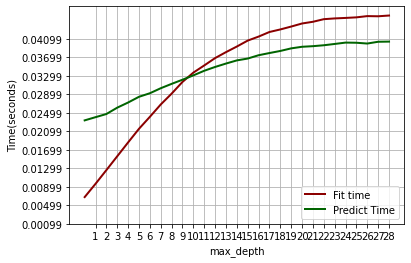

In [69]:
def normalize_data_points(points):
    return [float(i)/sum(points) for i in points]
lw = 2
plt.plot(normalize_data_points(fit_time_list), label="Fit time", color="darkred", lw=lw)
plt.plot(normalize_data_points(predict_time_list), label="Predict Time", color="darkgreen", lw=lw)
plt.xlabel(r"max_depth")
plt.ylabel("Time(seconds)")
plt.xticks(np.arange(1, len(fit_time_list), 1.0))
plt.yticks(np.arange(min(predict_time_list), max(fit_time_list), 0.004))
plt.grid()
plt.legend(loc='lower right')
plt.savefig(os.getcwd() +'/dt_fit_n_predict_time_income.png')


/nobackup/nitarora/ML/Supervised-Learning/DT


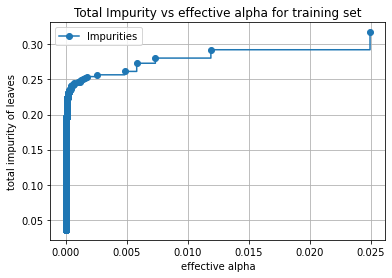

In [39]:
path = clf.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
fig, ax = plt.subplots()
plt.plot(ccp_alphas[:-1], impurities[:-1], label="Impurities",marker='o', drawstyle="steps-post")
plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")
plt.grid()
plt.legend()
plt.savefig(os.getcwd() +'/dt_impurity_vs_alpha_income.png')
plt.title("Total Impurity vs effective alpha for training set")
print(os.getcwd())

In [16]:
# As Alpha increases - more nodes are pruned which increases the impurity of the model
# The last ccp_alphas value prunes the whole tree and leaves only 1 node
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.0483515275290437


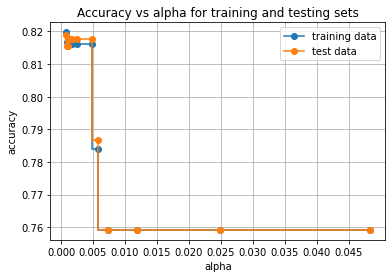

'So here we see that alpha from 0.025 to 0.005 gives us the max score for test data while keeping the impurity lower'

In [40]:
max_val = 15
train_scores = [clf.score(x_train, y_train) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas[::-1][:max_val], train_scores[::-1][:max_val], marker='o', label="training data", drawstyle="steps-post")
ax.plot(ccp_alphas[::-1][:max_val], test_scores[::-1][:max_val], marker='o', label="test data", drawstyle="steps-post")
plt.xticks(np.arange(0, 0.05, 0.005))
ax.legend()
plt.grid()
plt.savefig(os.getcwd() +'/dt_accuracy_vs_alpha_income.png')
plt.show()
"""So here we see that alpha from 0.025 to 0.005 gives us the max score for test data while keeping the impurity lower"""

In [18]:
from sklearn.model_selection import cross_val_score
crossValScores = cross_val_score(clf, X, y, cv=5)
print("Cross Valuation Scores for unpruned tree are ", crossValScores)
print("Mean accuracy score is ", crossValScores.mean())
print("Std accuracy score is ", crossValScores.std())

Cross Valuation Scores for unpruned tree are  [0.75909719 0.75921376 0.75921376 0.75921376 0.75921376]
Mean accuracy score is  0.7591904454179904
Std accuracy score is  4.662759153779561e-05


In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      4945
           1       0.55      0.53      0.54      1568

    accuracy                           0.78      6513
   macro avg       0.70      0.70      0.70      6513
weighted avg       0.78      0.78      0.78      6513



In [20]:
print(confusion_matrix(y_test, y_pred))

[[4263  682]
 [ 739  829]]


In [21]:
pipelineA = Pipeline([('scaler', StandardScaler()), 
                      ('dt', DecisionTreeClassifier(random_state=0))])
start_time = time.time()
p = pipelineA.fit(x_train, y_train)
print(f"DT Pipeline Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred_pipelineA = p.predict(x_test)
print(f"DT Pipeline Model: Predict Time: {time.time() - start_time}")

DT Pipeline Model: Fit Time: 0.047537803649902344
DT Pipeline Model: Predict Time: 0.002153158187866211


In [22]:
"""As we already saw from before that alpha between 0 and 0.05 provides highest test score and lower impurity"""
ccp_alphas = np.arange(0.000, 0.005, 0.001)
param = {'dt__max_depth': np.arange(1, 20), 'dt__criterion': ['gini', 'entropy'], 'dt__ccp_alpha': ccp_alphas, 'dt__class_weight': ['balanced']}
clf_cv = GridSearchCV(pipelineA, n_jobs=-1, param_grid=param, refit=True, cv=5, return_train_score=True)
start_time = time.time()
clf_cv = clf_cv.fit(x_train, y_train)
print(f"DT CV Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred_pipeline_cv = clf_cv.predict(x_test)
print(f"DT CV Model: Predict Time: {time.time() - start_time}")

DT CV Model: Fit Time: 6.109628677368164
DT CV Model: Predict Time: 0.0030977725982666016


In [76]:
start_time = time.time()
print(classification_report(y_test, y_pred_pipeline_cv))
print(clf_cv.best_score_, clf_cv.best_params_)
print(f"DT CV classification_report time: {time.time() - start_time}")
sc_df = pd.DataFrame(clf_cv.cv_results_)
sc_df.dropna(inplace=True)
# sc_df.sort_values(by="rank_test_score", ascending=True)

              precision    recall  f1-score   support

           0       0.76      0.65      0.70      4945
           1       0.24      0.35      0.28      1568

    accuracy                           0.58      6513
   macro avg       0.50      0.50      0.49      6513
weighted avg       0.63      0.58      0.60      6513

0.7819029444461435 {'dt__ccp_alpha': 0.003, 'dt__class_weight': 'balanced', 'dt__criterion': 'entropy', 'dt__max_depth': 7}
DT CV classification_report time: 0.008926153182983398


In [24]:
def plot_grid_search_validation_curve(grid, param_to_vary, title='Validation Curve', ylim=None, xlim=None, log=None):
    """Plots train and cross-validation scores from a GridSearchCV instance's
    best params while varying one of those params."""

    df_cv_results = pd.DataFrame(grid.cv_results_)
    train_scores_mean = df_cv_results['mean_train_score']
    valid_scores_mean = df_cv_results['mean_test_score']
    train_scores_std = df_cv_results['std_train_score']
    valid_scores_std = df_cv_results['std_test_score']

    param_cols = [c for c in df_cv_results.columns if c[:6] == 'param_']
    param_ranges = [grid.param_grid[p[6:]] for p in param_cols]
    param_ranges_lengths = [len(pr) for pr in param_ranges]

    train_scores_mean = np.array(train_scores_mean).reshape(*param_ranges_lengths)
    valid_scores_mean = np.array(valid_scores_mean).reshape(*param_ranges_lengths)
    train_scores_std = np.array(train_scores_std).reshape(*param_ranges_lengths)
    valid_scores_std = np.array(valid_scores_std).reshape(*param_ranges_lengths)

    param_to_vary_idx = param_cols.index('param_{}'.format(param_to_vary))

    slices = []
    for idx, param in enumerate(grid.best_params_):
        if (idx == param_to_vary_idx):
            slices.append(slice(None))
            continue
        best_param_val = grid.best_params_[param]
        idx_of_best_param = 0
        if isinstance(param_ranges[idx], np.ndarray):
            idx_of_best_param = param_ranges[idx].tolist().index(best_param_val)
        else:
            idx_of_best_param = param_ranges[idx].index(best_param_val)
        slices.append(idx_of_best_param)

    train_scores_mean = train_scores_mean[tuple(slices)]
    valid_scores_mean = valid_scores_mean[tuple(slices)]
    train_scores_std = train_scores_std[tuple(slices)]
    valid_scores_std = valid_scores_std[tuple(slices)]

    plt.clf()

    plt.title(title)
    plt.xlabel(param_to_vary)
    plt.ylabel('Score')

    if (ylim is None):
        plt.ylim(0.0, 1.1)
    else:
        plt.ylim(*ylim)

    if (not (xlim is None)):
        plt.xlim(*xlim)

    lw = 2

    plot_fn = plt.plot
    if log:
        plot_fn = plt.semilogx

    param_range = param_ranges[param_to_vary_idx]
#     if (not isinstance(param_range[0], numbers.Number)):
#         param_range = [str(x) for x in param_range]
    plot_fn(param_range, train_scores_mean, label='Training score', color='r', lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r', lw=lw)
    plot_fn(param_range, valid_scores_mean, label='Cross-validation score', color='b', lw=lw)
    plt.fill_between(param_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color='b', lw=lw)

    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [66]:
# plot_grid_search_validation_curve(clf_cv, 'dt__max_depth', log=False)
print(clf_cv.best_params_)

{'dt__ccp_alpha': 0.003, 'dt__class_weight': 'balanced', 'dt__criterion': 'entropy', 'dt__max_depth': 7}


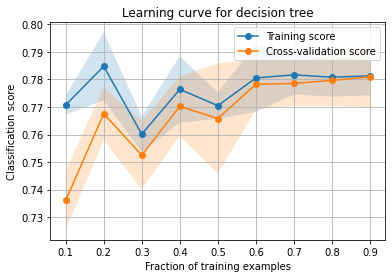

In [67]:
# Initial learning curve
# train_sizes = np.linspace(0.1, 1.0, 5)
train_sizes = np.arange(0.1, 1.0, 0.1)
clf_new = DecisionTreeClassifier(ccp_alpha=0.003, class_weight='balanced', criterion='entropy', max_depth=7)
_, train_scores, test_scores = learning_curve(clf_new, x_train, y_train, train_sizes=train_sizes, cv=5)

mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)
plt.plot(train_sizes, mean_train_scores, 'o-', label='Training score')
plt.fill_between(train_sizes, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, alpha=0.2)
plt.plot(train_sizes, mean_test_scores, 'o-', label='Cross-validation score')
plt.fill_between(train_sizes, mean_test_scores - std_test_scores, mean_test_scores + std_test_scores, alpha=0.2)
plt.title('Learning curve for decision tree')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.savefig(os.getcwd() + '/dt_learning_curve_income.png')
plt.show()

<module 'matplotlib.pyplot' from '/nobackup/nitarora/venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

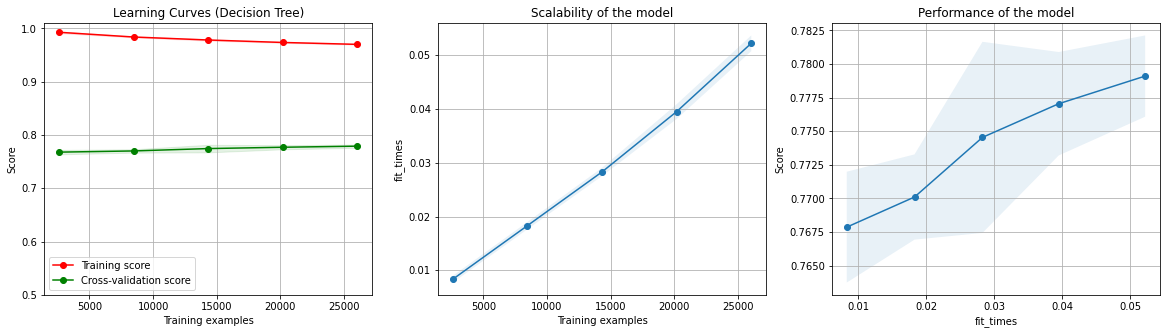

In [26]:
import numpy as np
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std, fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


title = "Learning Curves (Decision Tree)"
cv = ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None)
plot_learning_curve(clf_cv.estimator, title, X, y,  ylim=(0.5, 1.01), cv=cv, n_jobs=4)

As we already saw from before that alpha between 0 and 0.05 provides highest test score and lower impurity


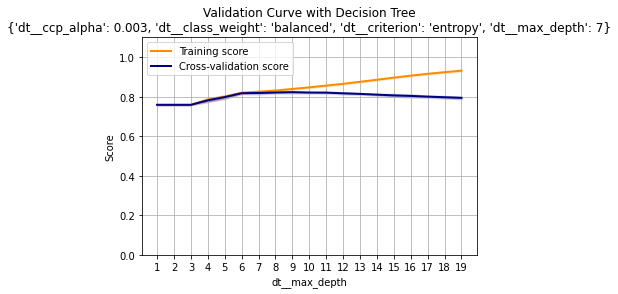

In [42]:
print(__doc__)

from sklearn.model_selection import validation_curve

param_range = np.arange(1, 20, 1)
train_scores, test_scores = validation_curve(clf_cv.estimator, X, y, param_name="dt__max_depth", param_range=param_range,scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title(f"Validation Curve with Decision Tree\n{clf_cv.best_params_}")
plt.xlabel(r"dt__max_depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="navy", lw=lw)
plt.legend(loc="best")
plt.xticks(param_range)
plt.grid()
plt.show()

In [28]:
# from dtreeviz.trees import dtreeviz
# viz = dtreeviz(clf, X, y['income'],
#                 target_name="income",
#                 feature_names=df.columns.tolist(),
#                 class_names=['low', 'high'])
# viz.view()

In [43]:
feature_columns = (df.columns.tolist())
feature_columns.remove('income')
dot_data = StringIO()

out_file = export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=feature_columns, class_names=['Very Low', 'Low', 'High','Very High'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('output_income.png')

Image(graph.create_png())

ValueError: Length of feature_names, 14 does not match number of features, 9